# Global GC* 

In [1]:
import os
from scipy import signal, stats
import numpy as np

# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# import modin.pandas as pd
import pandas as pd

import bisect
import importlib
import warnings
from pathlib import Path
import gc

from tqdm.notebook import trange, tqdm

import ete3
np.random.seed(7)

# import psutil, os
# def mem():
#     return psutil.Process(os.getpid()).memory_info().rss / 1024**3

Plotting setup:

In [17]:
%config InlineBackend.figure_formats = ['retina', 'png']
#%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# # Make inline plots vector graphics instead of raster graphics
# from matplotlib_inline.backend_inline import set_matplotlib_formats
# #set_matplotlib_formats('pdf', 'svg')
# set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import gridspec

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)

from shared_vars_and_func import *

Monospace font for numbers in tables:

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Paths to data and results:

In [4]:
data_path = Path('/project/Birds/faststorage/data')
results_path = Path('/project/Birds/faststorage/people/kmt/bird-hotspots/results')

Define column sets:

In [5]:
base_counts = ['nA', 'nG', 'nT', 'nC']

substitution_counts =  ['nA2C', 'nA2G', 'nA2T', 'nC2A', 'nC2G', 'nC2T',
                        'nG2A', 'nG2C', 'nG2T', 'nT2A', 'nT2C', 'nT2G']
cpg_substitution_counts =  ['nA2c', 'nA2g', 'nc2A', 'nc2g', 'nc2T',
                            'ng2A', 'ng2c', 'ng2T', 'nT2c', 'nT2g']
# in paired order
substitutions = ['rA2C', 'rT2G',
                 'rC2T', 'rG2A',
                 'rA2G', 'rT2C',
                 'rA2T', 'rT2A', 
                 'rC2A', 'rG2T',
                 'rC2G', 'rG2C']
# cpg_substitutions = ['rA2c', 'rT2g',
#                      'rc2T', 'rg2A',
#                      'rA2g', 'rT2c',
#                      'rc2A', 'rg2T',
#                      'rc2g', 'rg2c']


transitions = ['rA2G', 'rG2A', 'rT2C', 'rC2T']
# cpg_transitions = ['rA2g', 'rg2A', 'rT2c', 'rc2T']

transversions = [x for x in substitutions if x not in transitions]
# cpg_transversions = [x for x in cpg_substitutions if x not in cpg_transitions]

paired_patterns = [('rT2G', 'rA2C'),
                   ('rA2G', 'rT2C'),
                   ('rA2T', 'rT2A'), 
                   ('rG2T', 'rC2A'),
                   ('rC2G', 'rG2C'), 
                   ('rC2T', 'rG2A')]
# cpg_paired_patterns = [('rT2g', 'rA2c'),
#                        ('rA2g', 'rT2c'),
#                        ('rg2T', 'rc2A'),
#                        ('rc2g', 'rg2c'), 
#                        ('rc2T', 'rg2A')]

chromosomes = ['1', '1A', '2', '3', '4', '4A', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15']

# Load species details

In [6]:
species_details = pd.read_csv('/home/kmt/Birds/faststorage/data/species_details.txt', sep='\t')
species_details.head()

,species2014,species,english,latin,group,family,male_min,male_max,female_min,female_max,weight,order,order2014,branch_length
0,PICPU,PICPU,Downy Woodpecker,Picoides pubescens,woodpecker,woodpeckers,"20,70","32,20","20,70","32,20","26,45",39,1,0.143370
1,MERNU,MERNU,Carmine Bee-eater,Merops nubicus,woodpecker,bee-eaters,"34,00","59,00","34,00","59,00","46,5",38,2,0.102957
2,BUCRH,BUCRH,Rhinoceros Hornbill,Buceros rhinoceros,woodpecker,hornbills,"2465,00","2960,00","2040,00","2330,00","2448,75",37,3,0.099782
3,APAVI,APAVI,Bar-tailed Trogon,Apaloderma vittatum,woodpecker,trogons,"55,00","55,00","55,00","55,00",55,36,4,0.104832
4,LEPDI,LEPDI,Cuckoo Roller,Leptosomus discolor,woodpecker,cockoo-roller,"160,00","301,00","160,00","301,00","230,5",35,5,0.066956


# GC* by chromosome of each species

Mean GC* for each chromosome of each species:

In [7]:
chromosome_GCstar = pd.read_hdf('../results/chromosome_GCstar.h5')
chromosome_GCstar.head()

,species_code,chrom,GCstar,GCflux,GCcontent,species
0,PICPU,1,0.416573,0.714010,0.395756,Downy Woodpecker
1,PICPU,1A,0.459046,0.848588,0.407914,Downy Woodpecker
2,PICPU,2,0.506001,1.024294,0.412536,Downy Woodpecker
3,PICPU,3,0.463857,0.865173,0.406441,Downy Woodpecker
4,PICPU,4,0.531253,1.133349,0.411582,Downy Woodpecker


Size order of TAEGU chromosomes:

In [8]:
taegu_chromosome_sizes = pd.read_hdf('../results/taegu_chromosome_sizes.h5').sort_values('chrom_size')
taegu_chromosome_sizes.head()

,chrom,chrom_size
0,15,14428146
1,14,16419078
2,13,16962381
3,4A,20704505
4,10,20806668


Plot chromosome GC* across species (ordered by TAEGU chromosome size):

In [19]:
taegu_chromosome_size_order = taegu_chromosome_sizes.sort_values('chrom_size').chrom

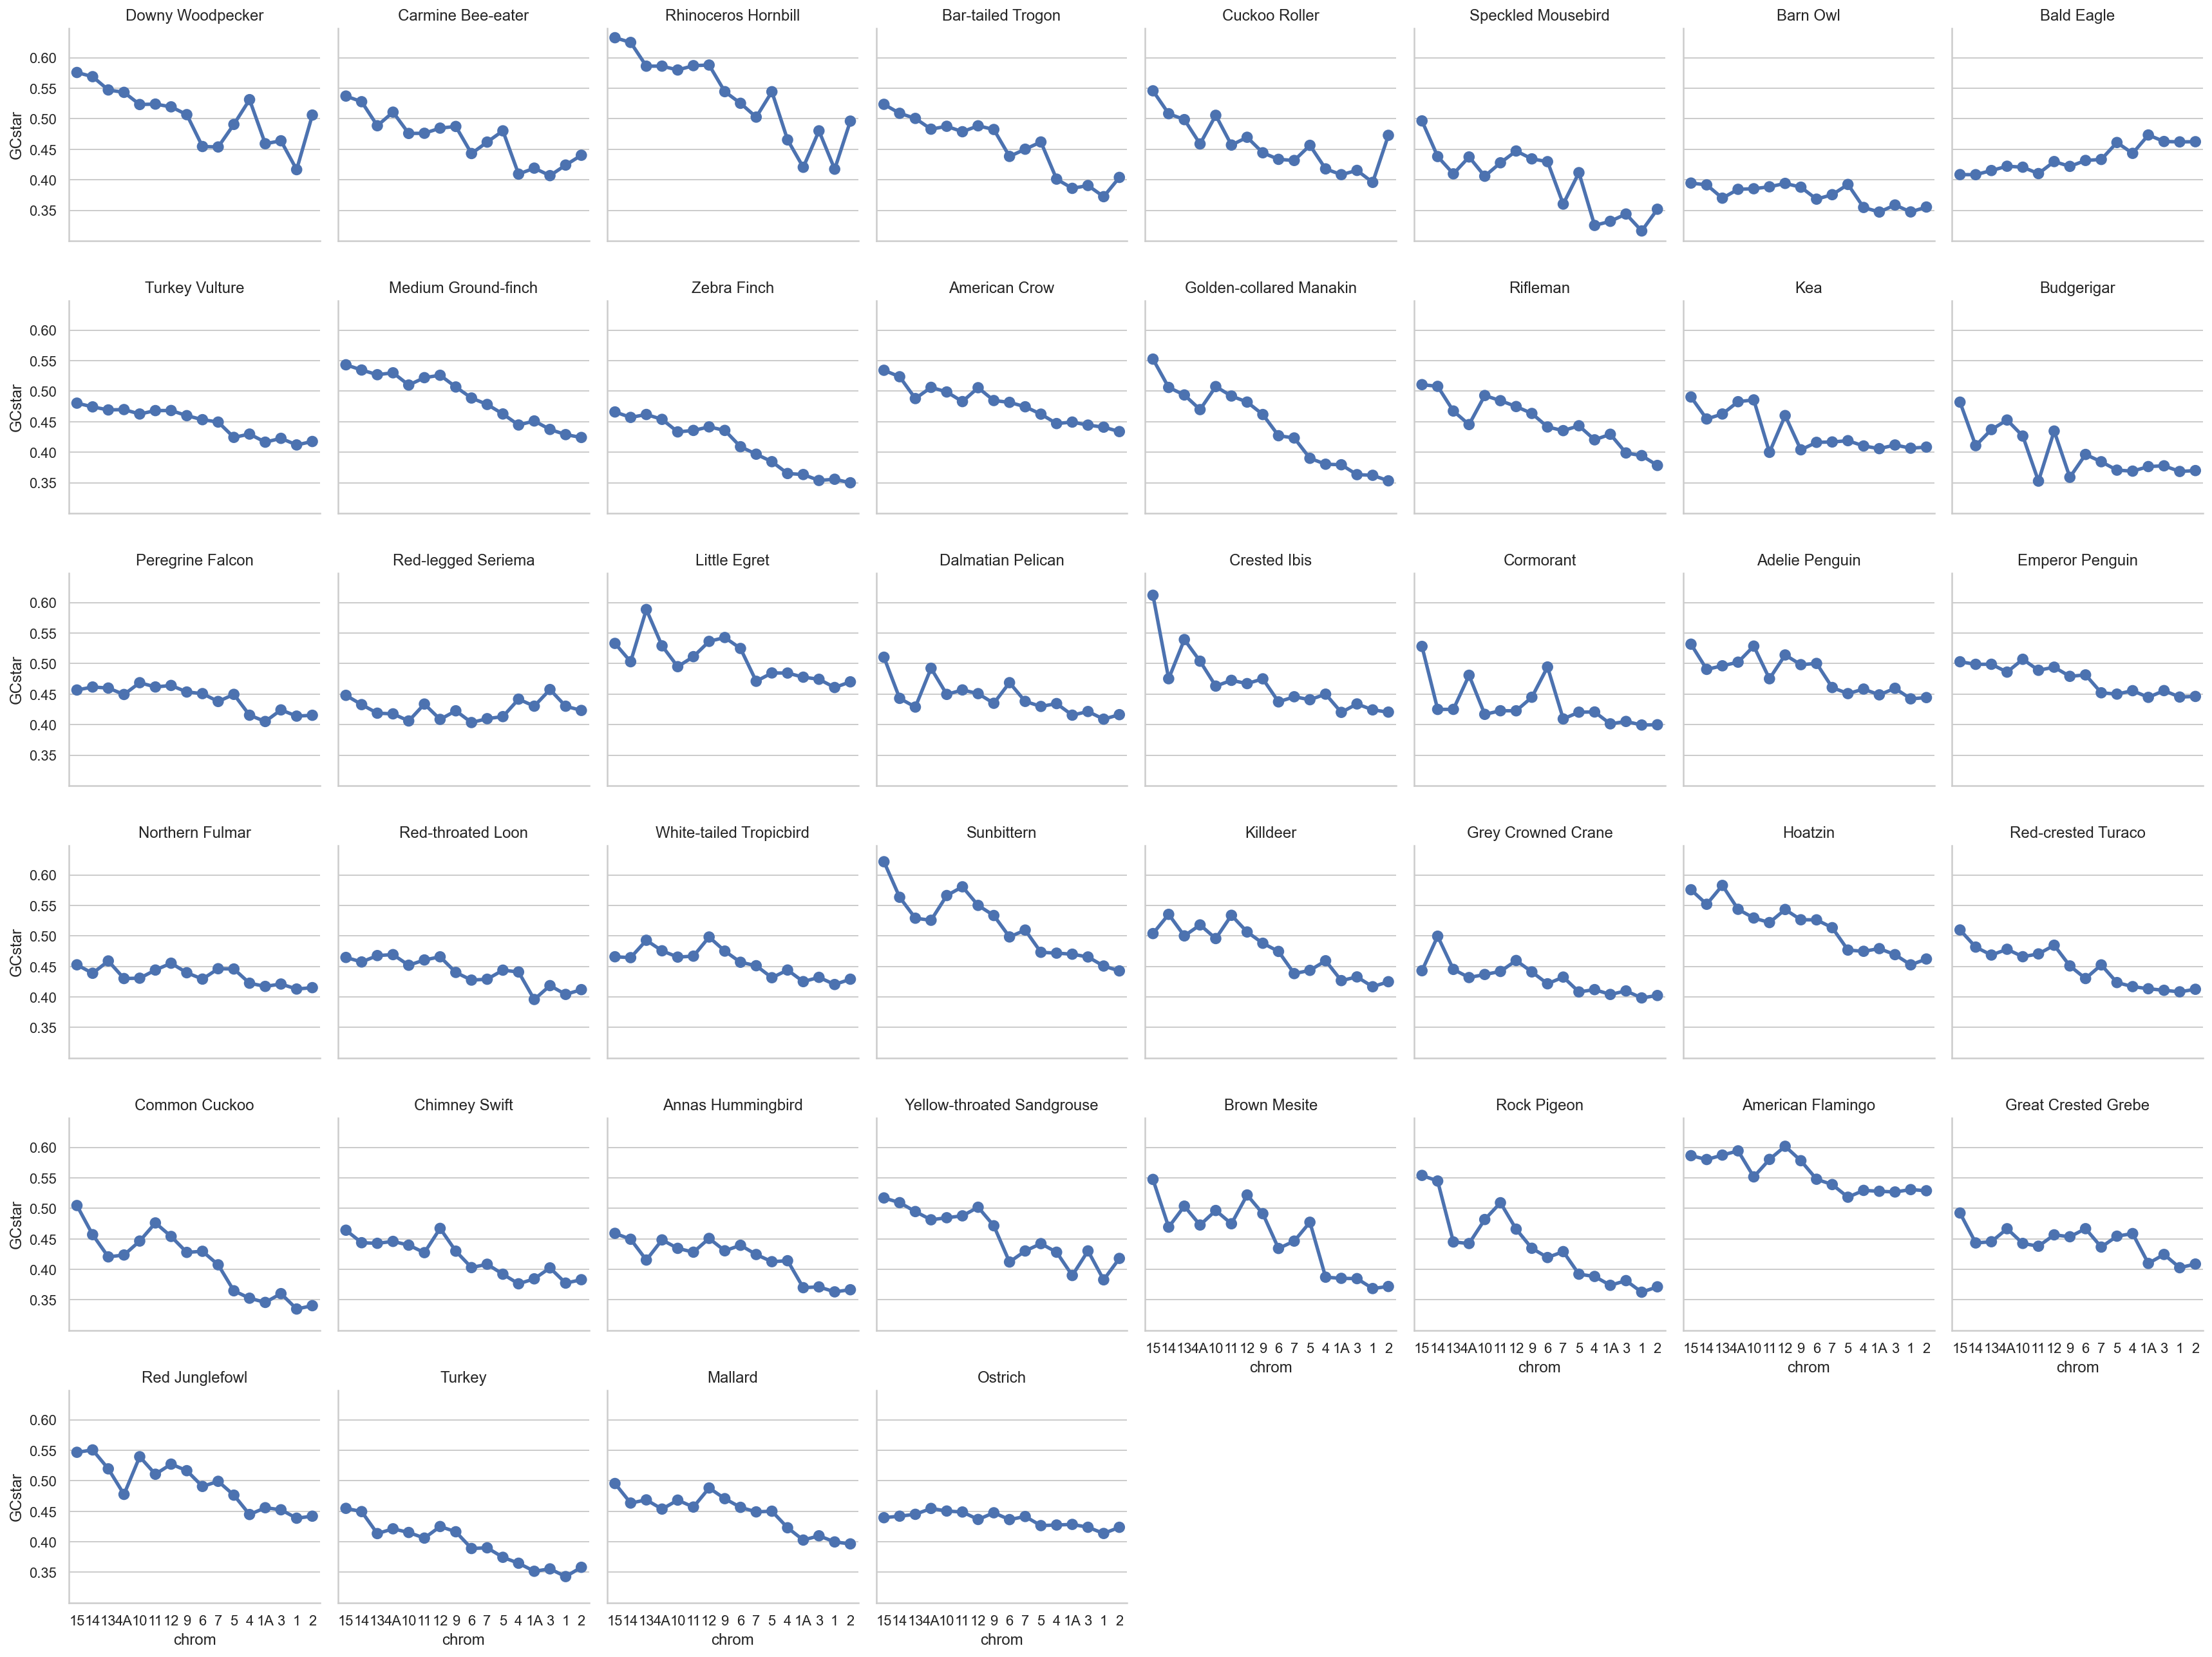

In [20]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=chromosome_GCstar, col='species',
                      col_order=chromosome_GCstar.species.unique().sort(),
                      col_wrap=8, sharex=True, sharey=True)
    g.map(sns.pointplot, "chrom", 'GCstar', errorbar=None, order=taegu_chromosome_size_order)
    g.set_titles(col_template="{col_name}") ;

In [21]:
taegu_chromosome_gcstar_order = chromosome_GCstar.loc[chromosome_GCstar.species_code == 'TAEGU'].sort_values('GCstar').chrom

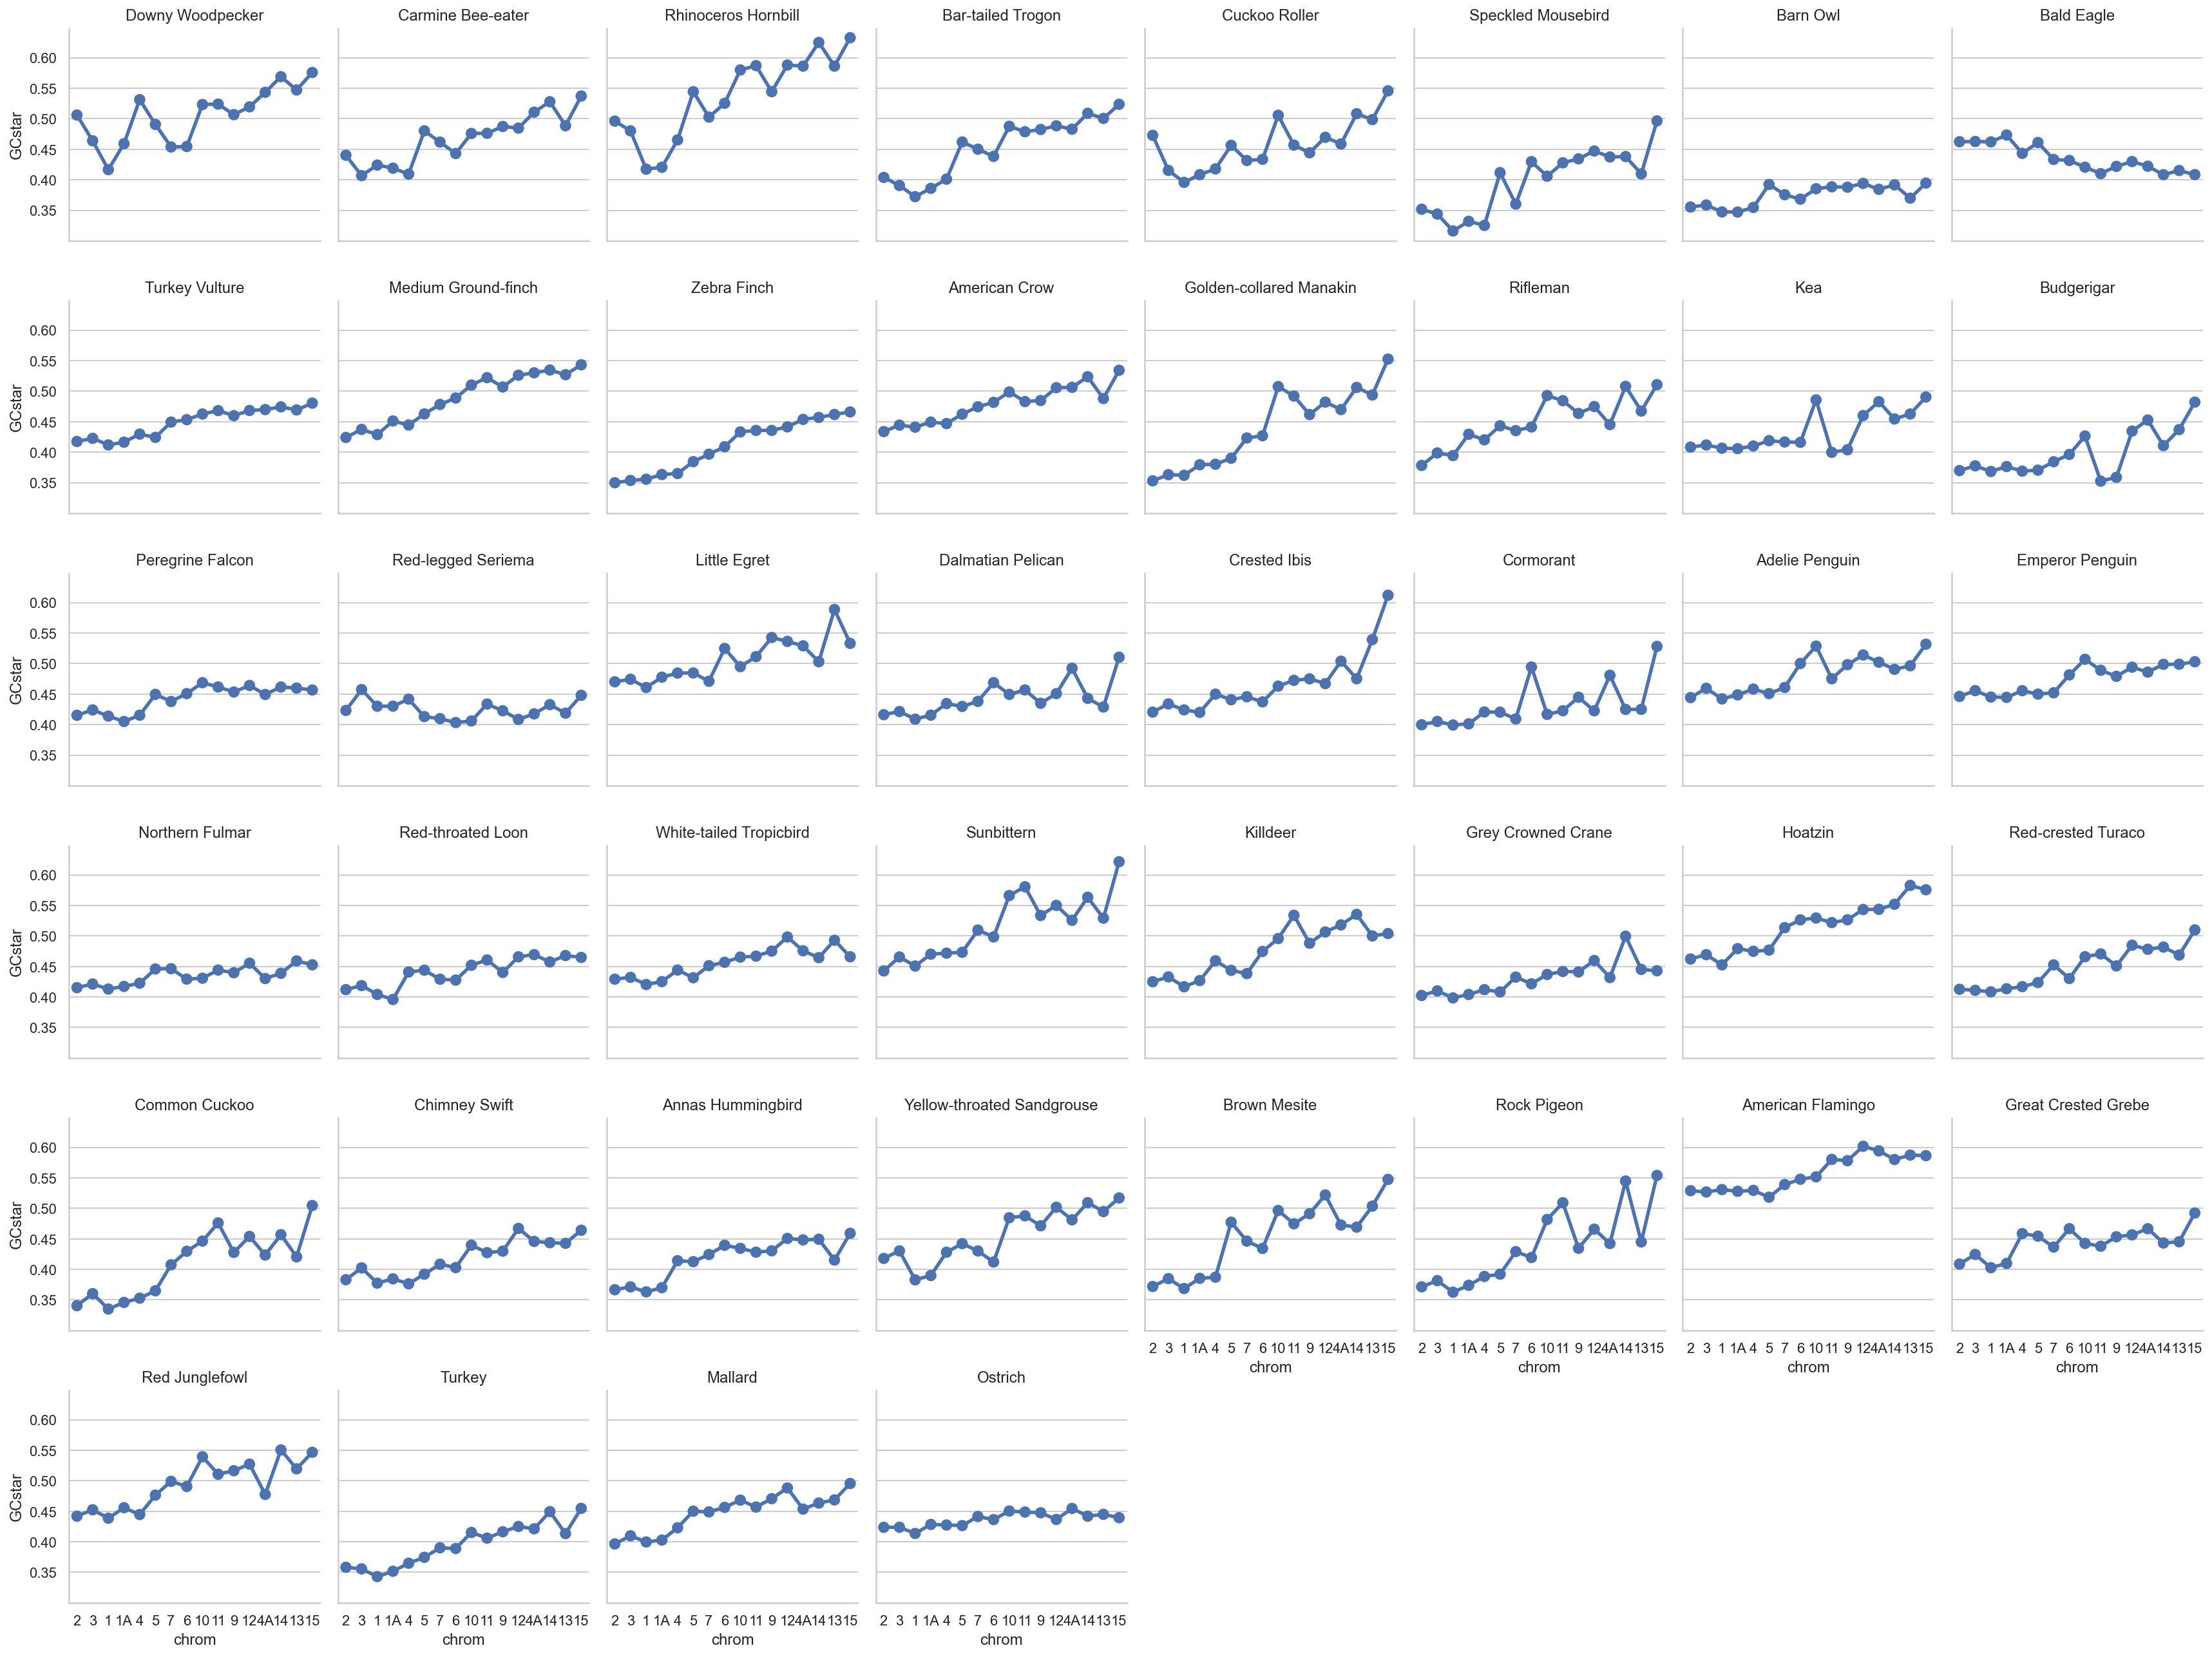

In [22]:
with sns.axes_style('whitegrid'):
    g = sns.FacetGrid(data=chromosome_GCstar, col='species', 
                      col_order=chromosome_GCstar.species.unique().sort(),
                      col_wrap=8, sharex=True, sharey=True)
    g.map(sns.pointplot, "chrom", 'GCstar', errorbar=None, order=taegu_chromosome_gcstar_order)
    g.set_titles(col_template="{col_name}") ;

### TODO: is the difference to TAEGU in rank ordering related to the amount of hotspot sharing?

log2 ratio of GC* of largest half vs smallest half of (TAEGU ordered) chromosomes:

In [23]:
def small_vs_large_log2ratio(df):
    large = ['1', '1A', '2', '3', '4', '4A', '5', '6']
    small = ['7', '9', '10', '11', '12', '13', '14', '15']
    return np.log10(df.loc[df.chrom.isin(small), 'GCstar'].mean() / df.loc[df.chrom.isin(large), 'GCstar'].mean())

chromosome_GCstar.groupby('species').apply(small_vs_large_log2ratio)

species
Adelie Penguin                0.032633
American Crow                 0.037045
American Flamingo             0.029286
Annas Hummingbird             0.039851
Bald Eagle                   -0.033799
Bar-tailed Trogon             0.069982
Barn Owl                      0.025985
Brown Mesite                  0.080525
Budgerigar                    0.028073
Carmine Bee-eater             0.047234
Chimney Swift                 0.046581
Common Cuckoo                 0.085345
Cormorant                     0.009096
Crested Ibis                  0.048778
Cuckoo Roller                 0.047734
Dalmatian Pelican             0.015268
Downy Woodpecker              0.038055
Emperor Penguin               0.029472
Golden-collared Manakin       0.098353
Great Crested Grebe           0.014185
Grey Crowned Crane            0.039269
Hoatzin                       0.048586
Kea                           0.026703
Killdeer                      0.046287
Little Egret                  0.029576
Mallard          

# 200kb window GC*

In [24]:
gcstar_200kb_windows = pd.read_hdf('../results/gcstar_200kb_windows.h5')
gcstar_200kb_windows.head()

,chrom,species,species_code,level_3,start,end,window_gcstar
0,1,Downy Woodpecker,PICPU,0,0,200000,NaN
1,1,Downy Woodpecker,PICPU,1,200000,400000,NaN
2,1,Downy Woodpecker,PICPU,2,400000,600000,0.377815
3,1,Downy Woodpecker,PICPU,3,600000,800000,NaN
4,1,Downy Woodpecker,PICPU,4,800000,1000000,0.399671


In [25]:
#gcstar_200kb_windows.groupby(['species', 'species_code']).window_gcstar.mean()

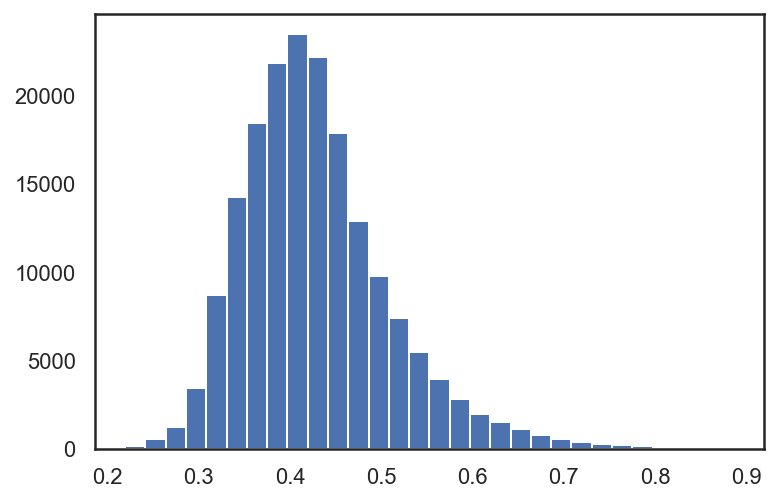

In [26]:
plt.hist(gcstar_200kb_windows.window_gcstar, bins=30) ;

In [27]:
gcstar_200kb_windows[['species', 'species_code', 'window_gcstar']].head(4100)

,species,species_code,window_gcstar
0,Downy Woodpecker,PICPU,NaN
1,Downy Woodpecker,PICPU,NaN
2,Downy Woodpecker,PICPU,0.377815
3,Downy Woodpecker,PICPU,NaN
4,Downy Woodpecker,PICPU,0.399671
...,...,...,...
4095,Downy Woodpecker,PICPU,0.646772
4096,Downy Woodpecker,PICPU,0.468722
4097,Downy Woodpecker,PICPU,0.395201
4098,Downy Woodpecker,PICPU,0.383937


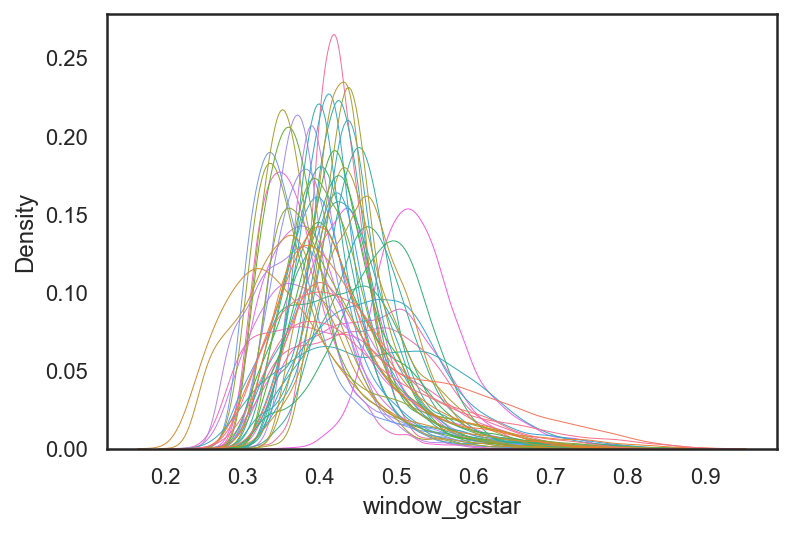

In [38]:
g = sns.kdeplot(data=gcstar_200kb_windows.reset_index(), x="window_gcstar", 
            hue="species", legend=False, linewidth=0.5) ;

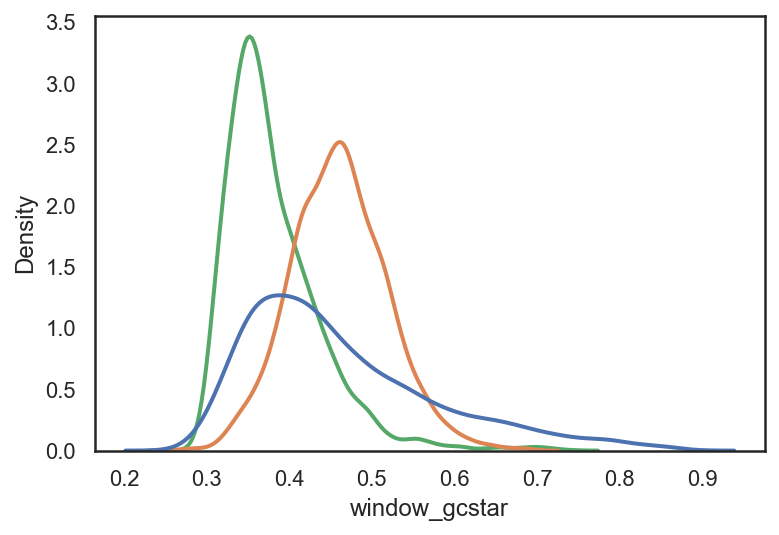

In [42]:
g = sns.kdeplot(data=gcstar_200kb_windows.loc[gcstar_200kb_windows.species_code.isin(['TAEGU', 'HALLE', 'PICPU'])].reset_index(), x="window_gcstar", 
            hue="species", legend=False, linewidth=2) ;